# Installations

In [1]:
# %pip install coppeliasim_zmqremoteapi_client

# Import libraries

In [2]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import numpy as np
from matplotlib import pyplot as plt

from time import sleep
import os
import json
import pandas as pd


from sklearn.preprocessing import LabelBinarizer

In [3]:
%matplotlib inline 

# Initialize CoppeliaSim

In [4]:

client = RemoteAPIClient()
sim = client.require('sim')

## Load Scene

In [5]:
fullFolder = os.getcwd() # get the current file location 
sceneFile = 'room_v2.ttt'
SCENE = os.path.join(fullFolder, sceneFile)

# Load the scene
sim.loadScene(SCENE)

# Get object handles
joint = sim.getObject('./Revolute_joint')
proximSensor = sim.getObject('./Proximity_sensor')
refHandle = sim.getObject('./ReferenceFrame')
planHandle = sim.getObject('./FloorPlan')

In [6]:
plan_position = sim.getObjectPosition(planHandle)

params = [sim.objfloatparam_objbbox_min_x,
            sim.objfloatparam_objbbox_max_x,
            sim.objfloatparam_objbbox_min_y,
            sim.objfloatparam_objbbox_max_y,
            sim.objfloatparam_objbbox_min_z,
            sim.objfloatparam_objbbox_max_z]
min_x, max_x, min_y, max_y, min_z, max_z = [sim.getObjectFloatParam(
    planHandle, p) for p in params]

sim.setObjectPosition(refHandle, [min_x, min_y, -0.1])

min_coords = (min_x, min_y)
max_coords = (max_x, max_y)
min_coords,max_coords

((-2.0825, -1.46), (2.0825, 1.46))

## Collect training data

### initialize variables

In [7]:
start = np.deg2rad(0) #
end = np.deg2rad(360) #

NoRefLocations = 8

max_radius = [0.5, 0.5, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5] # sample radius around reference location
N = 36 #
Samples = 20 # number of samples per reference location
z = 0.1 # height above the ground

angles = np.linspace(start, end, N) #split 0 - 2*pi into 36 
angles_deg = np.rad2deg(angles)

width = int(angles_deg[1]-angles_deg[0]) # width of the bar

### collecting training data

In [8]:
sim.stopSimulation(True)
# enable the stepping mode on the client:
sim.setStepping(True)

sim.startSimulation()

locations = []
seq_circular_path = False

for i in range(NoRefLocations):
    id = sim.getObject('./location', {'index':i}) # get the handle of the 6 locations
    max_radii = max_radius[i]
    for sample in range(Samples):

        if seq_circular_path:
            radius = np.random.uniform(low=0, high=max_radii)
        for t in angles: 
            if not seq_circular_path:
                radius = np.random.uniform(low=0, high=max_radii)
                
            pose = sim.getObjectPose(id, refHandle) # get Pose [position(3), quaternion(4)] (x, y, z, xi, yi, zi, w)
            xx = radius * np.cos(t)
            yy = radius * np.sin(t)
            pose[0] += xx
            pose[1] += yy
            pose[2] = z 
            
            sensorData = []
            sim.setObjectPose(joint, pose, refHandle) # place sensor above ground

            for theta in angles: 
                sim.setJointPosition(joint, theta) # rotate sensor
                
                sim.step() # step simulation

                dist = sim.readProximitySensor(proximSensor) # read distance
                noise = np.random.uniform(low=0, high=0.1) # generate noise
                # sensorData += noise
                depth = dist[1] + noise # add noise
                sensorData.append(depth) 


            location = {
                'dummy-id': id,
                'loc-id':i,
                'pose':pose,
                'sensorData':sensorData.copy()
            }

            
            locations.append(location)
            sleep(0.01)


### stop simulation

In [18]:
sim.stopSimulation(True)

binarize location id

In [19]:
cs = LabelBinarizer()
cs.fit_transform(list(range(NoRefLocations)))

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1]])

In [20]:
df = pd.DataFrame(locations)
df[['x', 'y', 'z', 'qx', 'qy', 'qz', 'qw']] = pd.DataFrame(df['pose'].tolist(), index=df.index)
df = df.drop(columns=['pose'])
df[[theta for theta in range(0, 360, 10)]] = pd.DataFrame(df['sensorData'].tolist(), index=df.index)
df = df.drop(columns=['sensorData'])
# df[[f'binID_{ref}' for ref in range(8)]] = pd.DataFrame(to_categorical(df['loc-id']), index=df.index)
df[[f'binID_{ref}' for ref in range(8)]] = pd.DataFrame(cs.transform(df['loc-id']), index=df.index)
df[['tag']] = 0 # 'val'
df.head()

,dummy-id,loc-id,x,y,z,qx,qy,qz,qw,0,...,350,binID_0,binID_1,binID_2,binID_3,binID_4,binID_5,binID_6,binID_7,tag
0,16,0,0.607953,2.385000,0.1,-1.136868e-13,0.000008,9.524887e-19,1.0,0.550114,...,0.556628,1,0,0,0,0,0,0,0,0
1,16,0,0.903408,2.452310,0.1,-1.136868e-13,0.000008,9.524887e-19,1.0,0.532471,...,0.507389,1,0,0,0,0,0,0,0,0
2,16,0,0.574065,2.400599,0.1,-1.136868e-13,0.000008,9.524887e-19,1.0,0.601203,...,0.535857,1,0,0,0,0,0,0,0,0
3,16,0,0.872754,2.588291,0.1,-1.136868e-13,0.000008,9.524887e-19,1.0,0.356452,...,0.401079,1,0,0,0,0,0,0,0,0
4,16,0,0.617251,2.459043,0.1,-1.136868e-13,0.000008,9.524887e-19,1.0,0.457452,...,0.466858,1,0,0,0,0,0,0,0,0


### visualizing samples of training data to reconstruct map

Text(0, 0.5, 'y(m)')

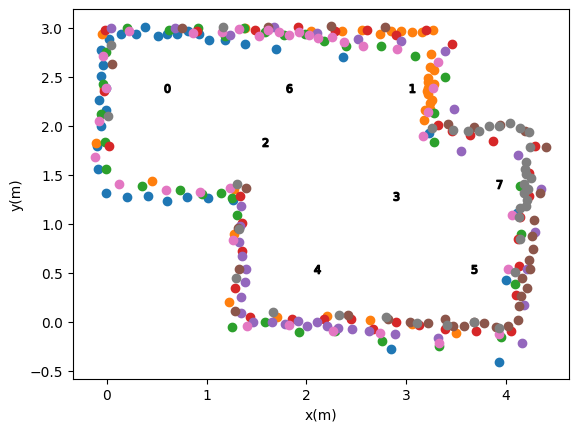

In [21]:
start = 9
N = 36

df_singe_sample_per_location = df.drop_duplicates('loc-id')

index = df_singe_sample_per_location.columns
end = N
for row in df_singe_sample_per_location.iloc:

    ref_x = row['x']
    ref_y = row['y']
    id = int(row['loc-id'])
    ps = np.array([[ref_x + depth * np.sin(np.deg2rad(-float(angle))), ref_y + depth * np.cos(np.deg2rad(-float(angle)))] for angle, depth in zip(index[start:start+N], row[index[start:start+N]].to_numpy())])
    plt.scatter(ps[:,0], ps[:,1])
    plt.plot(ref_x, ref_y, c='k', marker=f'${id}$')
    # break
# 
# plt.legend()
plt.xlabel('x(m)')
plt.ylabel('y(m)')

In [23]:
# imitating sensor data rotation
def rotate_data(row):
    N = 36
    dummy_id = row['dummy-id']
    loc_id = row['loc-id']
    pose = row[['x', 'y', 'z', 'qx', 'qy', 'qz', 'qw']]
    index = row.index
    tag = row['tag']
    # print(index)
    originalData = list(row[[theta for theta in range(0, 360, 10)]])

    loc_id_bin = row[[f'binID_{ref}' for ref in range(8)]]
    dummy_ids = []
    loc_ids = []
    poses = []
    loc_id_bins = []
    tags = []
    tags.append(tag)
    X = []
    for _ in range(N):
        X.append(originalData.copy())

        dummy_ids.append(dummy_id)
        loc_ids.append(loc_id)
        poses.append(pose)
        loc_id_bins.append(loc_id_bin)

        # Rotate the sensor data
        originalData = [originalData.pop()] + originalData
        tags.append(1) # train
    
    dummy_ids = np.expand_dims(np.array(dummy_ids), axis=1)
    loc_ids = np.expand_dims(np.array(loc_ids), axis=1)

    tags = np.expand_dims(np.array(tags[:N]), axis=1) # train
    
    poses = np.array(poses)
    loc_id_bins = np.array(loc_id_bins)
    stacked = np.hstack([dummy_ids, loc_ids, poses, X, loc_id_bins, tags])
    # print(loc_id_bins.shape, poses.shape, stacked.shape)
    return pd.DataFrame(stacked, columns=index)


### Data augmentation for robustness to rotation of sensor

In [24]:
# df_extended = []
for id in range(len(df)):
    row = df.iloc[id]
    df_ = rotate_data(row)
    if id == 0:
        df_extended = df_
        continue
    # df_extended.append(df_)
    df_extended = pd.concat([df_extended, df_])


### save dataset

In [25]:
df_extended.to_pickle('dataset.pkl')

## Testing

### Test Case 1

Data from random locations

- (random-x, y)
- (x, random-y)
- (random-x, random-y)

In [26]:
# enable the stepping mode on the client:

sim.stopSimulation(True)
sim.setStepping(True)

sim.startSimulation()
offset = 0.5
# min_x, max_x = min_coords[0] + offset, max_coords[0] - offset

# min_y, max_y = min_coords[1] + offset, max_coords[1] - offset


ref_loc_ids = np.random.permutation(NoRefLocations)
ref_loc_id = int(ref_loc_ids[0])

id = sim.getObject('./location', {'index':ref_loc_id})
position = sim.getObjectPosition(id, refHandle)

min_x, max_x = position[0] - offset, position[0] + offset

min_y, max_y = position[1] - offset, position[1] + offset
y_test = [
    [np.random.uniform(low =  min_x, high = max_x), position[1]],
    [position[0], np.random.uniform(low = min_y, high = max_y)],
    [np.random.uniform(low =  min_x, high = max_x), np.random.uniform(low = min_y, high = max_y)]
]
rgbs = []
size = 0.1#[0.1]*3
test_shapeHandle = []
locations_test = []
for loc in y_test:
    # shapeHandle = sim.createPrimitiveShape(sim.primitiveshape_spheroid, size)
    # test_shapeHandle.append(shapeHandle)
    shapeHandle = sim.createDummy(size)
    test_shapeHandle.append(shapeHandle)
    pos = loc+[z]
    print(pos)
    sim.setObjectPosition(shapeHandle, pos, refHandle)
    
    rgbData = list(np.random.rand(3))
    rgbs.append(rgbData)
    # sim.setShapeColor(shapeHandle, None, sim.colorcomponent_ambient_diffuse, rgbData)
    sim.setObjectColor(shapeHandle, 0, sim.colorcomponent_ambient_diffuse, rgbData)

    sim.setObjectPosition(joint, pos, refHandle)

    sensorData = []
    for theta in angles:
        sim.setJointPosition(joint, theta)
        sim.step()
        dist = sim.readProximitySensor(proximSensor)
        
        noise = np.random.uniform(low=0, high=0.1) # generate noise
        
        depth = dist[1] + noise # add noise
        sensorData.append(depth)
    pose = pos + [0, 0, 0]
    location = {
        'dummy-id': id,
        'loc-id': ref_loc_id,
        'pose':pose,
        'sensorData':sensorData.copy()
    }
    locations_test.append(location)
    sim.step()
    sleep(0.1)


[1.81339190832764, 0.5350000000000225, 0.1]
[1.9325016753644586, 1.028149273042955, 0.1]
[2.3210575059708605, 0.6267311872884229, 0.1]


### Test Case 2

Data from known reference location but at arbitary starting angle

In [27]:
sample_locs = 4 
loc_ids = np.random.permutation(NoRefLocations)
for i in range(sample_locs):
    loc_id = int(loc_ids[i]) # randomly choose location 0 - 6
    rgbData = list(np.random.rand(3))
    rgbs.append(rgbData)

    id = sim.getObject('./location', {'index':loc_id}) # get the handle of the 6 locations
    start_heading = np.random.uniform(low=0, high=(2*np.pi)) # randomly choose starting angle for the sensor
    
    pos = sim.getObjectPosition(id, refHandle)
    ori = sim.getObjectOrientation(id)

    sim.setObjectColor(id, 0, sim.colorcomponent_ambient_diffuse, rgbData)
    # sim.setObjectColor(id, 0, sim.colorcomponent_transparency, transparency)

    pos[2] = z
    ori[2] = start_heading
    
    

    sim.setObjectPosition(joint, pos, refHandle)
    sim.setObjectOrientation(joint, ori)
    sensorData = []
    for theta in angles:
        sim.setJointPosition(joint, theta)
        sim.step()
        dist = sim.readProximitySensor(proximSensor)
        
        noise = np.random.uniform(low=0, high=0.1) # generate noise
        
        depth = dist[1] + noise # add noise
        sensorData.append(depth)
    pose = pos+ori
    location = {
        'dummy-id': id,
        'loc-id':loc_id,
        'pose':pose,
        'sensorData':sensorData
    }
    sleep(0.02)
    locations_test.append(location)

    print(loc_id)
    
    # sleep(0.5)
    # pose

2
1
6
5


In [28]:
# Dump data to file
with open('testRegressSensorData.json', 'w') as fp:
    fp.writelines(json.dumps(locations_test))

In [29]:

sim.stopSimulation(True)

In [30]:

df_test = pd.DataFrame(locations_test)
df_test[['x', 'y', 'z', 'roll', 'pitch', 'yaw']] = pd.DataFrame(df_test['pose'].tolist(), index=df_test.index)
df_test = df_test.drop(columns=['pose'])
df_test[[theta for theta in range(0, 360, 10)]] = pd.DataFrame(df_test['sensorData'].tolist(), index=df_test.index)
df_test = df_test.drop(columns=['sensorData'])
df_test

,dummy-id,loc-id,x,y,z,roll,pitch,yaw,0,10,...,260,270,280,290,300,310,320,330,340,350
0,20,4,1.813392,0.535000,0.1,0.0,0.0,0.000000,2.426686,2.424178,...,2.438160,2.398437,2.483439,2.714258,2.282444,2.109509,2.744493,2.584676,2.429703,2.417011
1,20,4,1.932502,1.028149,0.1,0.0,0.0,0.000000,1.953756,2.003824,...,2.289258,2.269191,2.376092,1.933106,1.633104,1.957648,2.238810,2.095378,2.009839,1.973997
2,20,4,2.321058,0.626731,0.1,0.0,0.0,0.000000,2.332212,2.415879,...,1.918386,1.942723,1.936780,2.149761,2.154721,1.833177,1.705306,2.487324,2.368552,2.354559
3,18,2,1.082502,1.835000,0.1,-0.0,0.0,5.908503,1.178712,1.098187,...,3.406398,3.228157,3.133003,2.194985,2.291467,2.344274,1.840860,1.484091,1.304871,1.229792
4,17,1,2.657502,2.385000,0.1,-0.0,0.0,0.398866,0.665196,0.663879,...,0.601305,0.637592,0.796883,0.676427,0.665282,0.608184,0.628144,0.545811,0.564383,0.594324
5,22,6,1.607502,2.385000,0.1,-0.0,0.0,3.972919,3.455499,3.051573,...,1.514828,1.314409,1.221685,1.100131,2.398451,2.441828,2.488673,2.724933,3.068425,3.453858
6,21,5,3.632502,0.535000,0.1,-0.0,0.0,1.873366,1.767024,1.186554,...,1.502736,2.681612,2.935671,3.493334,4.302348,3.993685,2.344561,2.281825,2.354320,1.769773


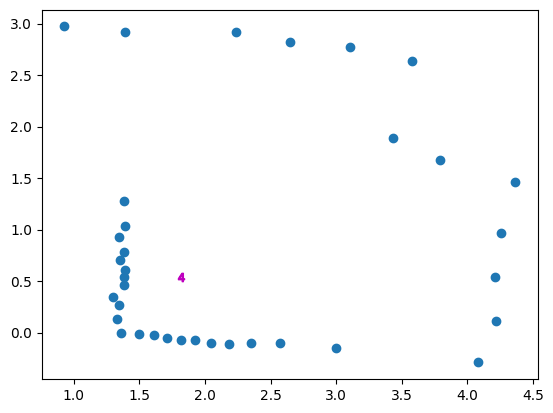

In [31]:
index = df_test.columns
for row in df_test.iloc:

    ref_x = row['x']
    ref_y = row['y']
    id = int(row['loc-id'])
    ps = np.array([[ref_x + depth * np.sin(np.deg2rad(-float(angle))), ref_y + depth * np.cos(np.deg2rad(-float(angle)))] for angle, depth in zip(index[start:start+N], row[index[start:start+N]].to_numpy())])
    # plt.scatter(ps[:,0], ps[:,1])
    plt.scatter(ps[0:end,0], ps[0:end,1])
    plt.plot(ref_x, ref_y, c='m', marker=f'${id}$')
    break

## Close Scene

In [32]:
# close scene
sim.closeScene()

0